In [7]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt

# === Funzione per estrarre le features dal livello layer3 e visualizzare mappe di attivazione ===
def extract_resnet_layer3_features_and_visualize(img_path):
    # Carica l'immagine
    img = Image.open(img_path)
    
    # Pre-processa l'immagine per ResNet (trasformazioni standard)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Aggiungi batch dimension

    # Carica la ResNet pre-addestrata
    resnet = models.resnet50(pretrained=True)
    resnet.eval()

    # Definire il hook per estrarre i dati dal layer3
    def hook_fn(module, input, output):
        # Salva l'output del layer3
        layer3_output.append(output)

    # Registriamo il hook al livello layer3 (ResNet ha layer3 in 'layer3')
    layer3_output = []
    hook = resnet.layer3[0].register_forward_hook(hook_fn)

    # Passa l'immagine attraverso il modello
    with torch.no_grad():
        resnet(img_tensor)

    # Rimuovi il hook
    hook.remove()
    return features

# === Esecuzione ===
img_path = "Part1/brain_glioma/brain_glioma_0002.jpg"
features = extract_resnet_layer3_features_and_visualize(img_path)

print(f"Vettore delle features: {features[:10]}")  # Mostra i primi 10 valori


Vettore delle features: [0.10401522 0.05138333 0.016945   0.10827071 0.02337234 0.01038369
 0.04877223 0.         0.06606087 0.01735999]


Task 2:

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

# Funzione per caricare l'immagine e fare la pre-elaborazione
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

# Funzione per estrarre le caratteristiche dal livello "layer3" della ResNet
def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features

# Funzione per estrarre la media su ciascuna mappa di attivazione
def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

# Funzione per processare tutte le immagini in più sottocartelle
def process_multiple_folders(base_folder, subfolders, model):
    features_list = []
    filenames_list = []
    labels_list = []

    for subfolder in subfolders:
        subfolder_path = os.path.join(base_folder, subfolder)
        print(f"[INFO] Elaboro la sottocartella: {subfolder}")

        for filename in os.listdir(subfolder_path):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg', '.bmp', '.tif')):
                img_path = os.path.join(subfolder_path, filename)
                print(f"[INFO] Elaboro: {filename}")
                features = extract_and_process_image(img_path, model)
                features_list.append(features)
                filenames_list.append(filename)
                labels_list.append(subfolder)

    return np.array(features_list), np.array(filenames_list), np.array(labels_list)

# === Inizializzazione del modello ===
model = models.resnet50(pretrained=True)
model.eval()

# === Esecuzione ===
base_folder = "Part1"
subfolders = ["brain_glioma", "brain_menin", "brain_tumor"]
features, filenames, labels = process_multiple_folders(base_folder, subfolders, model)

# === Salvataggio in .npz ===
np.savez("resnet_features_all.npz", features=features, filenames=filenames, labels=labels)
print("[SALVATO] Dati ResNet salvati in resnet_features_all.npz")
print(f"[FINE] Elaborate {len(filenames)} immagini da {len(subfolders)} classi.")

[INFO] Elaboro la sottocartella: brain_glioma
[INFO] Elaboro: brain_glioma_0717.jpg
[INFO] Elaboro: brain_glioma_0071.jpg
[INFO] Elaboro: brain_glioma_0065.jpg
[INFO] Elaboro: brain_glioma_0703.jpg
[INFO] Elaboro: brain_glioma_0059.jpg
[INFO] Elaboro: brain_glioma_0918.jpg
[INFO] Elaboro: brain_glioma_0930.jpg
[INFO] Elaboro: brain_glioma_0924.jpg
[INFO] Elaboro: brain_glioma_0273.jpg
[INFO] Elaboro: brain_glioma_0515.jpg
[INFO] Elaboro: brain_glioma_0501.jpg
[INFO] Elaboro: brain_glioma_0267.jpg
[INFO] Elaboro: brain_glioma_0529.jpg
[INFO] Elaboro: brain_glioma_0298.jpg
[INFO] Elaboro: brain_glioma_0307.jpg
[INFO] Elaboro: brain_glioma_0461.jpg
[INFO] Elaboro: brain_glioma_0475.jpg
[INFO] Elaboro: brain_glioma_0313.jpg
[INFO] Elaboro: brain_glioma_0449.jpg
[INFO] Elaboro: brain_glioma_0663.jpg
[INFO] Elaboro: brain_glioma_0105.jpg
[INFO] Elaboro: brain_glioma_0111.jpg
[INFO] Elaboro: brain_glioma_0677.jpg
[INFO] Elaboro: brain_glioma_0887.jpg
[INFO] Elaboro: brain_glioma_0139.jpg
[INF

Task 3:

In [2]:
pip install scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]
Note: you may need to restart the kernel to use updated packages.


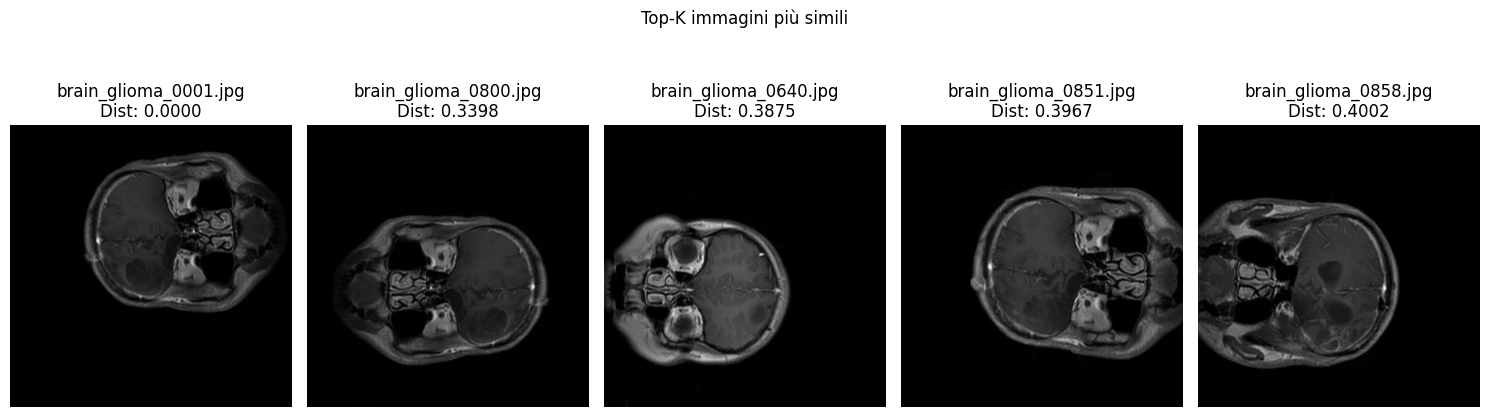

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import models
from torchvision import transforms

# === Funzioni già definite nel tuo codice ===
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features

def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

# === Funzione per trovare immagini simili ===
def find_top_k_similar(query_img_path, k, features_npz_path, model, image_folder):
    # Carica le feature, nomi file e label salvati
    data = np.load(features_npz_path)
    features = data['features']
    filenames = data['filenames']
    labels = data['labels']

    # Estrai feature per immagine di query
    query_feature = extract_and_process_image(query_img_path, model)

    # Calcola distanza euclidea tra query e tutte le immagini salvate
    dists = np.linalg.norm(features - query_feature, axis=1)

    # Trova gli indici delle k immagini più simili (con distanza minore)
    top_k_indices = np.argsort(dists)[:k]

    # Visualizza risultati
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_k_indices):
        img_path = os.path.join(image_folder, labels[idx], filenames[idx])
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{filenames[idx]}\nDist: {dists[idx]:.4f}")
    plt.suptitle("Top-K immagini più simili")
    plt.tight_layout()
    plt.show()

# === Esempio di utilizzo ===
if __name__ == "__main__":
    model = models.resnet50(pretrained=True)
    model.eval()

    # Parametri
    query_image_path = "Part1/brain_glioma/brain_glioma_0001.jpg"  # Sostituisci con il tuo file immagine
    k = 5
    features_npz = "resnet_features_all.npz"
    base_folder = "Part1"

    find_top_k_similar(query_image_path, k, features_npz, model, base_folder)


/Users/giari/Desktop/uni/MDB/DBmulti/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/giari/Desktop/uni/MDB/DBmulti/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


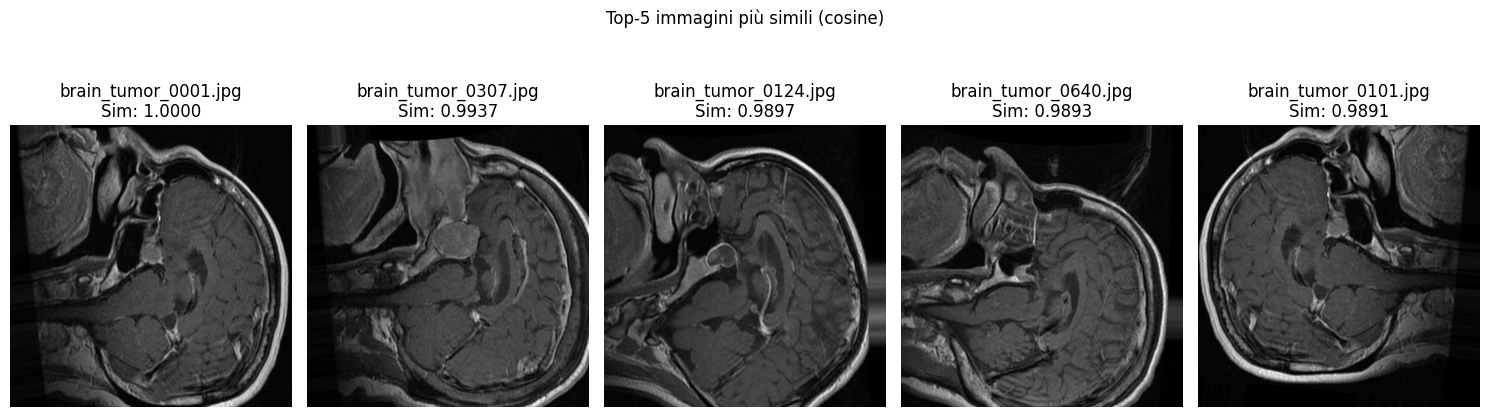

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from torchvision import models
from torchvision import transforms
from sklearn.metrics.pairwise import cosine_similarity

# --- Le funzioni preprocess_image, extract_resnet_features, extract_and_process_image restano identiche ---

def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor

def extract_resnet_features(img_tensor, model):
    def hook_fn(module, input, output):
        hook_fn.features = output

    hook = model.layer3[0].register_forward_hook(hook_fn)
    model(img_tensor)
    hook.remove()

    features = hook_fn.features.squeeze()
    return features

def extract_and_process_image(img_path, model):
    img_tensor = preprocess_image(img_path)
    features = extract_resnet_features(img_tensor, model)
    features_vector = features.detach().mean(dim=[1, 2]).cpu().numpy()
    return features_vector

# --- Funzione con scelta metrica ---

def find_top_k_similar(query_img_path, k, features_npz_path, model, image_folder, metric="euclidean"):
    """
    Trova e visualizza le k immagini più simili rispetto all'immagine di query.

    Parametri:
    - query_img_path: percorso immagine di query
    - k: numero di immagini simili da mostrare
    - features_npz_path: file .npz con features, filenames, labels
    - model: modello ResNet già caricato
    - image_folder: cartella base delle immagini (per ricostruire i path)
    - metric: "euclidean" o "cosine" (default euclidean)
    """

    # Carica dati
    data = np.load(features_npz_path)
    features = data['features']
    filenames = data['filenames']
    labels = data['labels']

    # Estrai feature per immagine query
    query_feature = extract_and_process_image(query_img_path, model).reshape(1, -1)

    if metric == "euclidean":
        # Distanza euclidea
        dists = np.linalg.norm(features - query_feature, axis=1)
        # Più piccoli sono migliori (vicinanza)
        top_k_indices = np.argsort(dists)[:k]

    elif metric == "cosine":
        # Similarità coseno
        sim = cosine_similarity(query_feature, features)[0]  # shape: (num_features,)
        # Più alti sono migliori (similarità)
        top_k_indices = np.argsort(sim)[::-1][:k]

    else:
        raise ValueError("Metric must be 'euclidean' or 'cosine'")

    # Visualizzazione
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_k_indices):
        img_path = os.path.join(image_folder, labels[idx], filenames[idx])
        img = Image.open(img_path).convert("RGB")
        plt.subplot(1, k, i + 1)
        plt.imshow(img)
        plt.axis('off')
        if metric == "euclidean":
            plt.title(f"{filenames[idx]}\nDist: {dists[idx]:.4f}")
        else:
            plt.title(f"{filenames[idx]}\nSim: {sim[idx]:.4f}")

    plt.suptitle(f"Top-{k} immagini più simili ({metric})")
    plt.tight_layout()
    plt.show()

# === Esempio di uso ===
if __name__ == "__main__":
    model = models.resnet50(pretrained=True)
    model.eval()

    query_image_path = "Part1/brain_tumor/brain_tumor_0001.jpg"  # sostituisci con la tua immagine
    k = 5
    features_npz = "resnet_features_all.npz"
    base_folder = "Part1"

    # Chiamata con distanza euclidea
    #find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="euclidean")

    # Chiamata con similarità coseno
    find_top_k_similar(query_image_path, k, features_npz, model, base_folder, metric="cosine")
